In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
new_transactions = pd.read_csv('../input/new_merchant_transactions.csv')
historical_transactions = pd.read_csv('../input/historical_transactions.csv')
historical_transactions = pd.concat([historical_transactions, new_transactions])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)

In [3]:
def aggregate_historical_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max']
        }
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

history = aggregate_historical_transactions(historical_transactions)
history[:10]

,card_id,transactions_count,authorized_flag_sum,authorized_flag_mean,category_1_sum,category_1_mean,merchant_id_nunique,merchant_category_id_nunique,state_id_nunique,city_id_nunique,subsector_id_nunique,purchase_amount_sum,purchase_amount_median,purchase_amount_max,purchase_amount_min,purchase_amount_std,installments_sum,installments_median,installments_max,installments_min,installments_std,purchase_date_ptp,month_lag_min,month_lag_max
0,C_ID_00007093c1,151,116,0.768212,28,0.185430,31,19,4,5,13,-78.173565,-0.596447,1.507069,-0.728876,0.296638,194,1.0,6,1,0.760504,36210196.0,-12,2
1,C_ID_0001238066,149,146,0.979866,4,0.026846,90,35,6,19,19,-87.297257,-0.648184,0.768095,-0.740897,0.186974,240,1.0,10,-1,1.596920,18480736.0,-5,2
2,C_ID_0001506ef0,68,64,0.941176,0,0.000000,29,20,2,3,12,-36.049233,-0.706036,1.493545,-0.740491,0.466421,1,0.0,1,0,0.121268,37299509.0,-13,1
3,C_ID_0001793786,247,220,0.890688,2,0.008097,150,57,5,11,25,-37.015633,-0.469323,4.554145,-0.745405,0.850432,5,0.0,1,0,0.141116,29748035.0,-9,2
4,C_ID_000183fdda,155,148,0.954839,4,0.025806,84,38,7,10,21,-75.428717,-0.662834,2.764788,-0.737892,0.508951,280,1.0,10,-1,2.070500,23001039.0,-6,2
5,C_ID_00024e244b,70,53,0.757143,0,0.000000,19,10,2,3,8,-41.552753,-0.709342,2.258395,-0.740897,0.416742,5,0.0,1,0,0.259399,34540529.0,-13,0
6,C_ID_0002709b5a,76,70,0.921053,6,0.078947,38,19,4,4,14,-49.678369,-0.679033,-0.336684,-0.727388,0.077859,130,1.0,12,-1,2.165276,40761632.0,-13,2
7,C_ID_00027503e2,42,24,0.571429,0,0.000000,12,7,2,2,6,-31.123047,-0.741213,-0.734135,-0.745871,0.003334,0,0.0,0,0,0.000000,20483171.0,-8,0
8,C_ID_000298032a,31,29,0.935484,0,0.000000,21,13,2,6,10,-16.634288,-0.641872,2.577843,-0.719529,0.579963,0,0.0,0,0,0.000000,35351881.0,-11,2
9,C_ID_0002ba3c2e,73,58,0.794521,0,0.000000,38,23,2,3,15,-46.414055,-0.682534,-0.097011,-0.742400,0.127228,0,0.0,0,0,0.000000,29372442.0,-9,2


In [4]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'median', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'median', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['median', 'min', 'max', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(historical_transactions) 
final_group[:10]

,card_id,month_lag_median,month_lag_min,month_lag_max,month_lag_std,purchase_amount_count_median,purchase_amount_count_min,purchase_amount_count_max,purchase_amount_count_std,purchase_amount_sum_median,purchase_amount_sum_min,purchase_amount_sum_max,purchase_amount_sum_std,purchase_amount_median_median,purchase_amount_median_min,purchase_amount_median_max,purchase_amount_median_std,purchase_amount_min_median,purchase_amount_min_min,purchase_amount_min_max,purchase_amount_min_std,purchase_amount_max_median,purchase_amount_max_min,purchase_amount_max_max,purchase_amount_max_std,purchase_amount_std_median,purchase_amount_std_min,purchase_amount_std_max,purchase_amount_std_std,installments_count_median,installments_count_min,installments_count_max,installments_count_std,installments_sum_median,installments_sum_min,installments_sum_max,installments_sum_std,installments_median_median,installments_median_min,installments_median_max,installments_median_std,installments_min_median,installments_min_min,installments_min_max,installments_min_std,installments_max_median,installments_max_min,installments_max_max,installments_max_std,installments_std_median,installments_std_min,installments_std_max,installments_std_std
0,C_ID_00007093c1,-5.5,-12,2,4.309458,11.0,2,19,5.176553,-5.846215,-10.423035,-1.328524,2.927273,-0.580812,-0.664262,-0.399495,0.064717,-0.721363,-0.728876,-0.572600,0.041183,-0.070715,-0.656749,1.507069,0.530398,0.189298,0.010625,0.672414,0.166427,11.0,2,19,5.176553,12.0,2,29,7.058624,1.0,1.0,1.5,0.133631,1.0,1,1,0.000000,2.5,1,6,1.556624,0.518349,0.000000,2.000000,0.608879
1,C_ID_0001238066,-1.5,-5,2,2.449490,20.0,2,37,11.147549,-11.668582,-21.442877,-1.302784,6.443929,-0.651042,-0.676433,-0.566770,0.036509,-0.729575,-0.740897,-0.718267,0.006474,-0.319193,-0.574013,0.768095,0.419073,0.110799,0.096319,0.338234,0.083246,20.0,2,37,11.147549,25.5,4,79,22.058364,1.0,1.0,2.0,0.353553,1.0,-1,1,0.925820,3.0,3,10,3.181981,1.151411,0.769670,3.244654,0.854321
2,C_ID_0001506ef0,-5.5,-13,1,4.496641,3.0,1,18,4.435125,-1.747065,-11.071218,0.034381,2.908833,-0.700972,-0.740491,0.017190,0.266732,-0.724368,-0.740491,-0.701828,0.010902,0.380081,-0.722369,1.493545,0.756526,0.462839,0.010463,1.048722,0.397585,3.0,1,18,4.435125,0.0,0,1,0.267261,0.0,0.0,0.0,0.000000,0.0,0,0,0.000000,0.0,0,1,0.267261,0.000000,0.000000,0.408248,0.113228
3,C_ID_0001793786,-3.5,-9,2,3.605551,20.5,2,38,13.069453,-1.375301,-10.843852,2.091705,4.595767,-0.455934,-0.607274,0.295654,0.290044,-0.715555,-0.745405,-0.189409,0.154416,1.674457,1.018452,4.554145,1.218750,0.922841,0.537941,1.147357,0.218644,20.5,2,38,13.069453,0.0,0,2,0.792961,0.0,0.0,0.0,0.000000,0.0,0,0,0.000000,0.0,0,1,0.452267,0.000000,0.000000,0.238833,0.098925
4,C_ID_000183fdda,-2.0,-6,2,2.738613,22.0,3,28,10.449615,-7.581191,-15.638962,-0.226840,6.133196,-0.656899,-0.686802,-0.002645,0.219976,-0.731881,-0.737892,-0.444875,0.094287,0.334099,-0.459601,2.764788,1.059914,0.387087,0.096408,0.858688,0.279667,22.0,3,28,10.449615,37.0,1,60,19.048914,1.0,1.0,2.0,0.353553,1.0,-1,1,1.000000,10.0,1,10,3.427827,2.023326,1.004988,3.041381,0.703288
5,C_ID_00024e244b,-6.0,-13,0,4.330867,4.0,1,21,5.140338,-2.702909,-7.280285,-0.734165,1.920145,-0.722805,-0.734902,-0.641722,0.031044,-0.733384,-0.740897,-0.680145,0.016051,-0.705510,-0.734165,2.258395,0.813330,0.016732,0.000000,0.705075,0.198295,4.0,1,21,5.140338,0.0,0,3,0.869718,0.0,0.0,0.5,0.138675,0.0,0,0,0.000000,0.0,0,1,0.438529,0.000000,0.000000,0.707107,0.260774
6,C_ID_0002709b5a,-4.5,-13,2,4.448114,5.5,1,12,3.837353,-3.610382,-8.136886,-0.611669,2.601699,-0.681633,-0.703579,-0.481690,0.068766,-0.713061,-0.727388,-0.611669,0.036824,-0.576244,-0.692256,-0.336684,0.109722,0.061442,0.020601,0.205069,0.055405,5.5,1,12,3.837353,8.5,-1,36,9.335034,1.0,-1.0,6.0,1.511858,1.0,-1,1,0.726273,1.5,-1,12,3.315796,1.253566,0.000000,4.599517,1.508537
7,C_ID_00027503e2,-4.0,-8,0,2.738613,4.0,1,10,2.449490,-2.966669,-7.421564,-0.740897,1.817939,-0.741273,-0.745871,-0.737892,0.002277,-0.

In [5]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
#     df['year'] = df['first_active_month'].dt.year
#     df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

In [6]:
train = read_data('../input/train.csv')
test = read_data('../input/test.csv')

target = train['target']
del train['target']

In [7]:
train = pd.merge(train, history, on='card_id')
test = pd.merge(test, history, on='card_id')

train = pd.merge(train, final_group, on='card_id')
test = pd.merge(test, final_group, on='card_id')

In [8]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]

In [9]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

In [10]:
features = list(train[features].columns)
categorical_feats = [c for c in features if 'feature_' in c]

In [11]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': 7,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 1,
         "verbosity": -1}

In [12]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

fold n°0


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.76937	valid_1's rmse: 3.8228
[200]	training's rmse: 3.72665	valid_1's rmse: 3.79288
[300]	training's rmse: 3.69604	valid_1's rmse: 3.77596
[400]	training's rmse: 3.67353	valid_1's rmse: 3.76579
[500]	training's rmse: 3.65717	valid_1's rmse: 3.76013
[600]	training's rmse: 3.6444	valid_1's rmse: 3.75651
[700]	training's rmse: 3.63348	valid_1's rmse: 3.75441
[800]	training's rmse: 3.62336	valid_1's rmse: 3.75291
[900]	training's rmse: 3.61388	valid_1's rmse: 3.75158
[1000]	training's rmse: 3.60511	valid_1's rmse: 3.75068
[1100]	training's rmse: 3.59719	valid_1's rmse: 3.74998
[1200]	training's rmse: 3.58899	valid_1's rmse: 3.74931
[1300]	training's rmse: 3.58153	valid_1's rmse: 3.74889
[1400]	training's rmse: 3.57435	valid_1's rmse: 3.74842
[1500]	training's rmse: 3.56732	valid_1's rmse: 3.74818
[1600]	training's rmse: 3.5604	valid_1's rmse: 3.74822
[1700]	training's rmse: 3.5532	valid_1's rmse: 3.7478

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.78629	valid_1's rmse: 3.74838
[200]	training's rmse: 3.7419	valid_1's rmse: 3.72171
[300]	training's rmse: 3.71049	valid_1's rmse: 3.70752
[400]	training's rmse: 3.68755	valid_1's rmse: 3.69957
[500]	training's rmse: 3.6711	valid_1's rmse: 3.69587
[600]	training's rmse: 3.65811	valid_1's rmse: 3.69363
[700]	training's rmse: 3.64681	valid_1's rmse: 3.69222
[800]	training's rmse: 3.63643	valid_1's rmse: 3.69139
[900]	training's rmse: 3.62663	valid_1's rmse: 3.69073
[1000]	training's rmse: 3.61769	valid_1's rmse: 3.69024
[1100]	training's rmse: 3.60907	valid_1's rmse: 3.68985
[1200]	training's rmse: 3.60107	valid_1's rmse: 3.68966
[1300]	training's rmse: 3.59361	valid_1's rmse: 3.68936
[1400]	training's rmse: 3.58616	valid_1's rmse: 3.68919
[1500]	training's rmse: 3.57893	valid_1's rmse: 3.68907
[1600]	training's rmse: 3.57154	valid_1's rmse: 3.68906
Early stopping, best iteration is:
[1534]	training's

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.79082	valid_1's rmse: 3.72498
[200]	training's rmse: 3.74747	valid_1's rmse: 3.69903
[300]	training's rmse: 3.71735	valid_1's rmse: 3.68446
[400]	training's rmse: 3.69389	valid_1's rmse: 3.6758
[500]	training's rmse: 3.67707	valid_1's rmse: 3.67153
[600]	training's rmse: 3.66503	valid_1's rmse: 3.66934
[700]	training's rmse: 3.65413	valid_1's rmse: 3.66775
[800]	training's rmse: 3.64399	valid_1's rmse: 3.66658
[900]	training's rmse: 3.63508	valid_1's rmse: 3.66573
[1000]	training's rmse: 3.6266	valid_1's rmse: 3.66516
[1100]	training's rmse: 3.61848	valid_1's rmse: 3.66498
[1200]	training's rmse: 3.61024	valid_1's rmse: 3.66445
[1300]	training's rmse: 3.60182	valid_1's rmse: 3.66439
[1400]	training's rmse: 3.59401	valid_1's rmse: 3.66416
[1500]	training's rmse: 3.58701	valid_1's rmse: 3.66374
[1600]	training's rmse: 3.58036	valid_1's rmse: 3.66352
[1700]	training's rmse: 3.57326	valid_1's rmse: 3.66

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.74261	valid_1's rmse: 3.92469
[200]	training's rmse: 3.70098	valid_1's rmse: 3.8951
[300]	training's rmse: 3.67052	valid_1's rmse: 3.8781
[400]	training's rmse: 3.64812	valid_1's rmse: 3.86835
[500]	training's rmse: 3.63178	valid_1's rmse: 3.86326
[600]	training's rmse: 3.61849	valid_1's rmse: 3.86031
[700]	training's rmse: 3.60683	valid_1's rmse: 3.85832
[800]	training's rmse: 3.59587	valid_1's rmse: 3.85642
[900]	training's rmse: 3.58661	valid_1's rmse: 3.85543
[1000]	training's rmse: 3.57762	valid_1's rmse: 3.85461
[1100]	training's rmse: 3.56958	valid_1's rmse: 3.8537
[1200]	training's rmse: 3.56197	valid_1's rmse: 3.85307
[1300]	training's rmse: 3.55469	valid_1's rmse: 3.8526
[1400]	training's rmse: 3.54722	valid_1's rmse: 3.85207
[1500]	training's rmse: 3.53983	valid_1's rmse: 3.85154
[1600]	training's rmse: 3.53325	valid_1's rmse: 3.85143
[1700]	training's rmse: 3.52643	valid_1's rmse: 3.8511

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.78942	valid_1's rmse: 3.73538
[200]	training's rmse: 3.7462	valid_1's rmse: 3.7081
[300]	training's rmse: 3.71511	valid_1's rmse: 3.69379
[400]	training's rmse: 3.69226	valid_1's rmse: 3.68551
[500]	training's rmse: 3.67558	valid_1's rmse: 3.68135
[600]	training's rmse: 3.66273	valid_1's rmse: 3.67897
[700]	training's rmse: 3.65108	valid_1's rmse: 3.6773
[800]	training's rmse: 3.64064	valid_1's rmse: 3.67665
[900]	training's rmse: 3.63088	valid_1's rmse: 3.67625
[1000]	training's rmse: 3.62123	valid_1's rmse: 3.67583
[1100]	training's rmse: 3.61279	valid_1's rmse: 3.67562
[1200]	training's rmse: 3.60468	valid_1's rmse: 3.67548
[1300]	training's rmse: 3.59679	valid_1's rmse: 3.67542
[1400]	training's rmse: 3.58938	valid_1's rmse: 3.67518
[1500]	training's rmse: 3.58169	valid_1's rmse: 3.67525
Early stopping, best iteration is:
[1400]	training's rmse: 3.58938	valid_1's rmse: 3.67518


In [13]:
print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

CV score: 3.72556 


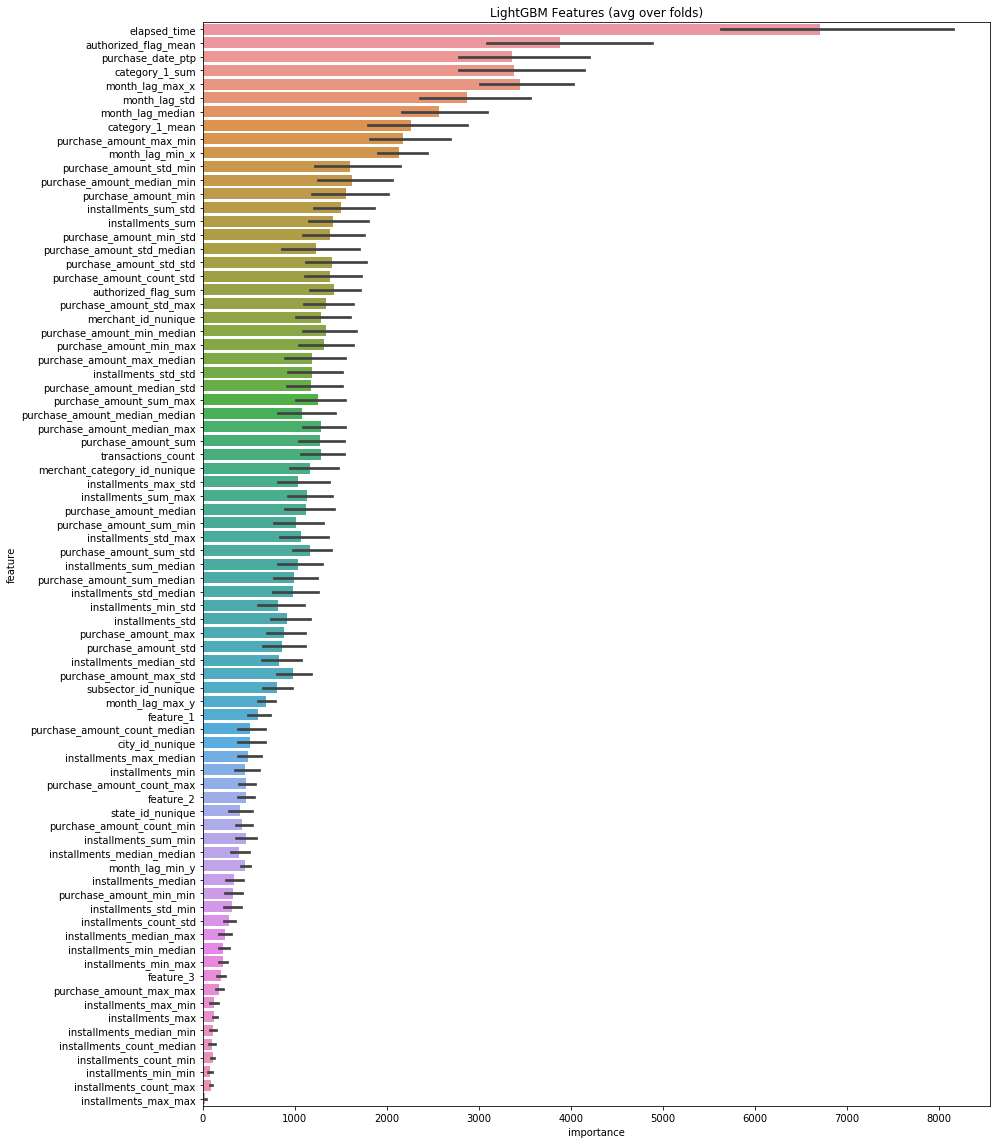

In [14]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,16))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [15]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)